In [176]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

color_pal = sns.color_palette()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/EGX 30 Data June.csv


# EGX30

**Loading the dataset into a Pandas dataframe**

In [139]:
df = pd.read_csv("/kaggle/input/EGX 30 Data June.csv")

In [140]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/05/2024,"26,634.30","26,915.46","26,915.46","26,245.33",240.86M,-1.26%
1,06/04/2024,"26,973.00","26,852.33","27,158.65","26,852.33",352.59M,0.52%
2,06/03/2024,"26,834.47","26,869.85","27,003.04","26,760.84",267.86M,-0.13%
3,06/02/2024,"26,869.85","26,922.76","27,140.20","26,753.70",225.28M,-0.20%
4,05/30/2024,"26,922.76","27,089.68","27,116.25","26,683.97",352.59M,-0.62%
...,...,...,...,...,...,...,...
3704,03/05/2009,"3,575.93","3,566.55","3,605.23","3,565.60",54.81M,0.47%
3705,03/04/2009,"3,559.09","3,524.63","3,562.48","3,524.63",68.90M,1.19%
3706,03/03/2009,"3,517.33","3,524.81","3,533.41","3,494.95",57.01M,-1.88%
3707,03/02/2009,"3,584.86","3,640.55","3,641.19","3,584.86",46.91M,-1.70%


**Data Preprocessing**
* Converting string values to float values
* Using a datetime type as index to allow time series analysis

In [141]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

In [142]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    df[col] = df[col].str.replace(',', '').astype(float)

df['Vol.'] = df['Vol.'].apply(convert_volume_to_float)
df['Change %']= df['Change %'].apply(convert_change_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062
...,...,...,...,...,...,...
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188


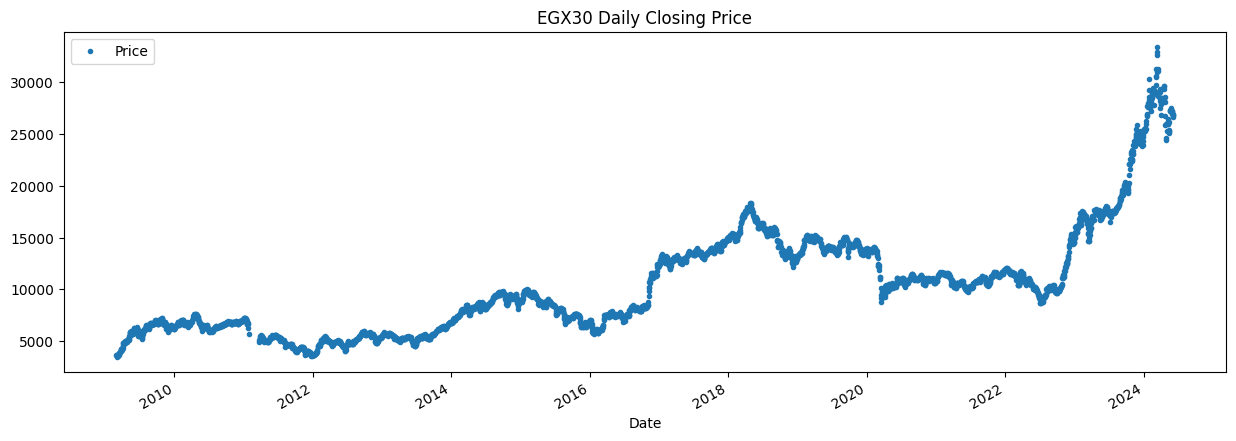

In [143]:
df.plot(y='Price', figsize=(15,5), color= color_pal[0],
        title='EGX30 Daily Closing Price', use_index=True, style='.')
plt.show()

**Train/Test Split**
* The main Egyptian index changed its name to EGX30 on March 1st, 2009
* Our training set is from this date until February 2024
* Our test set is the past three months (March, April and May 2024)
* Our splitting technique ensures that no future leakage affects our model's prediction

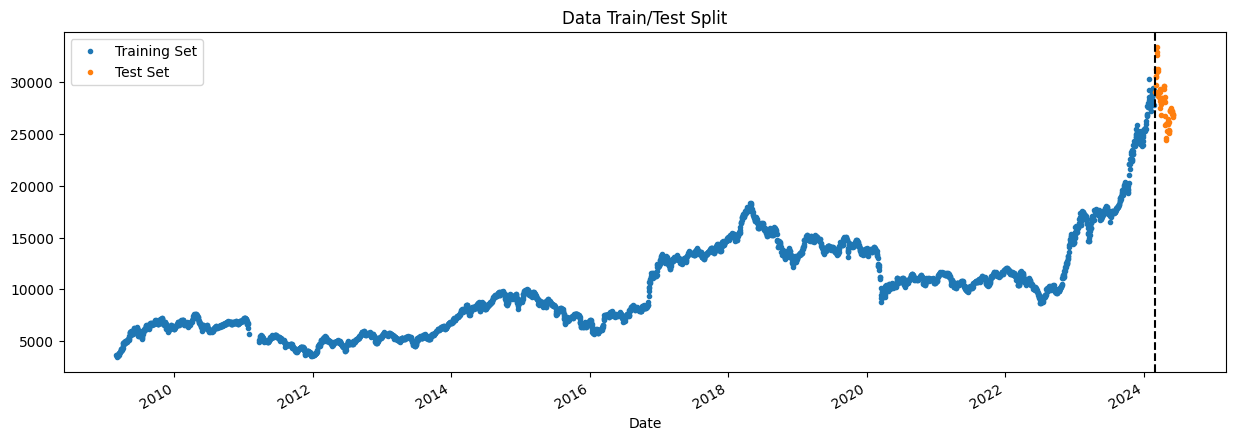

In [144]:
train = df.loc[df.index < '03-01-2024']
test = df.loc[df.index >= '03-01-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Price', label='Training Set', title= 'Data Train/Test Split', style='.')
test.plot(ax=ax, y='Price', label='Test Set', style='.')
ax.axvline('03-01-2024', color='black', ls='--')
plt.show()

**Feature Engineering**
* Extracting additional temporal features from the data to offer further insights
* Creating lagged features to train our model to predict the current trading day's closing price


In [145]:
def create_features(df,cols,lags):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df = df.sort_index(ascending= True)
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.loc[df.index > '03-15-2009']
    df = df.sort_index(ascending= False)
    #df = df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
    return df

cols = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
lags = [x for x in range(1, 11)]
aug_df = create_features(df, cols, lags)

In [146]:
aug_df

,Price,Open,High,Low,Vol.,Change %,quarter,year,Price_lag_1,Price_lag_2,...,Change %_lag_1,Change %_lag_2,Change %_lag_3,Change %_lag_4,Change %_lag_5,Change %_lag_6,Change %_lag_7,Change %_lag_8,Change %_lag_9,Change %_lag_10
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126,2,2024,26973.00,26834.47,...,0.0052,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052,2,2024,26834.47,26869.85,...,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013,2,2024,26869.85,26922.76,...,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020,2,2024,26922.76,27089.68,...,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032,0.0449
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062,2,2024,27089.68,27194.51,...,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032,0.0449,0.0327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-22,3982.28,3968.32,3982.65,3965.55,75190000.0,0.0042,1,2009,3965.80,3914.65,...,0.0131,0.0261,0.0090,-0.0101,0.0321,-0.0032,0.0234,0.0112,0.0032,0.0047
2009-03-19,3965.80,3941.76,3988.21,3937.12,82060000.0,0.0131,1,2009,3914.65,3814.93,...,0.0261,0.0090,-0.0101,0.0321,-0.0032,0.0234,0.0112,0.0032,0.0047,0.0119
2009-03-18,3914.65,3876.34,3920.19,3876.34,80810000.0,0.0261,1,2009,3814.93,3780.84,...,0.0090,-0.0101,0.0321,-0.0032,0.0234,0.0112,0.0032,0.0047,0.0119,-0.0188


In [147]:
aug_df.head()

,Price,Open,High,Low,Vol.,Change %,quarter,year,Price_lag_1,Price_lag_2,...,Change %_lag_1,Change %_lag_2,Change %_lag_3,Change %_lag_4,Change %_lag_5,Change %_lag_6,Change %_lag_7,Change %_lag_8,Change %_lag_9,Change %_lag_10
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126,2,2024,26973.00,26834.47,...,0.0052,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052,2,2024,26834.47,26869.85,...,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013,2,2024,26869.85,26922.76,...,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020,2,2024,26922.76,27089.68,...,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032,0.0449
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062,2,2024,27089.68,27194.51,...,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,0.0001,-0.0001,-0.0032,0.0449,0.0327


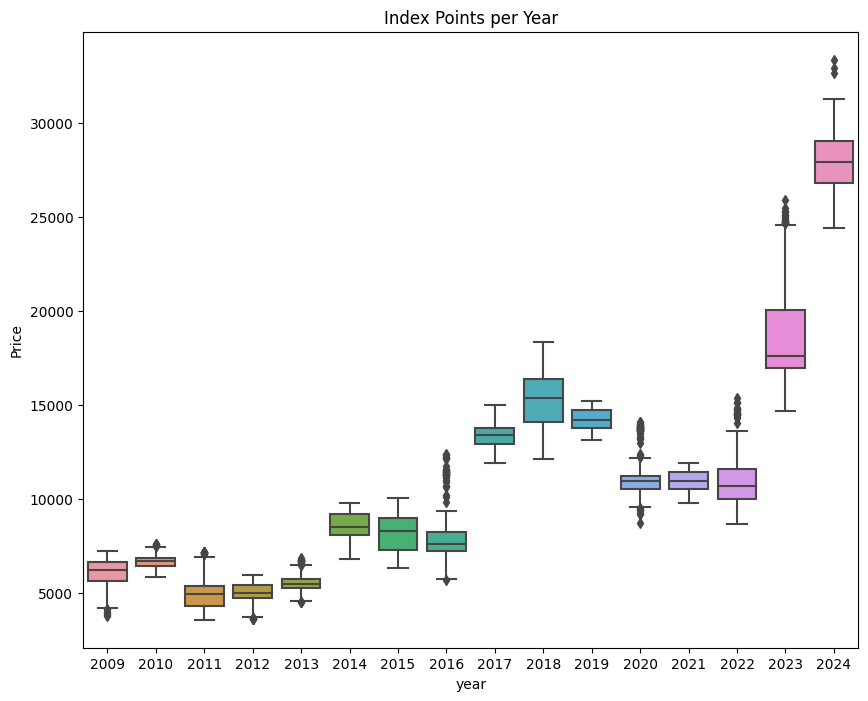

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='year', y='Price')
ax.set_title('Index Points per Year')
plt.show()

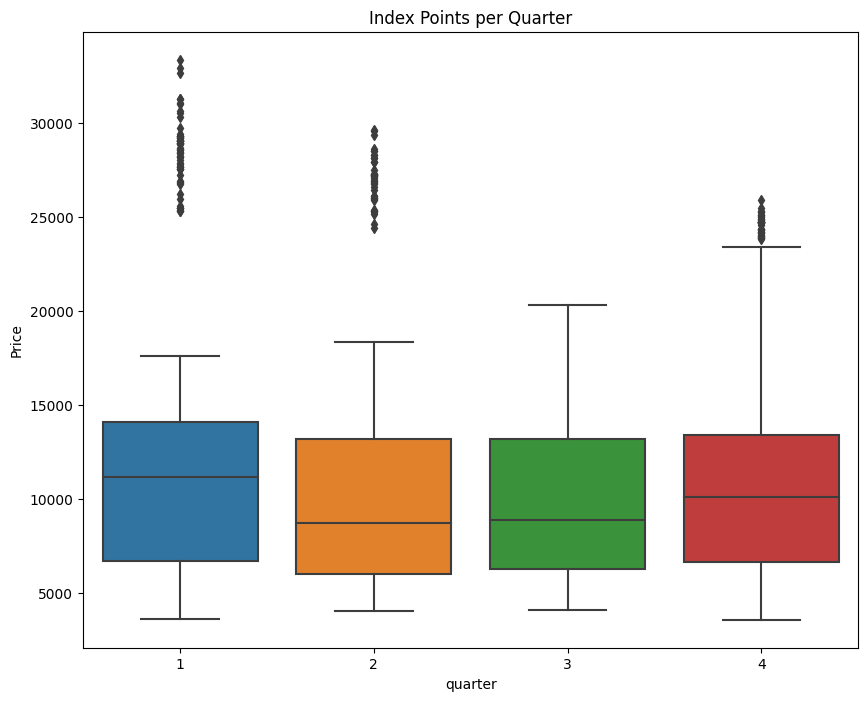

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='quarter', y='Price')
ax.set_title('Index Points per Quarter')
plt.show()

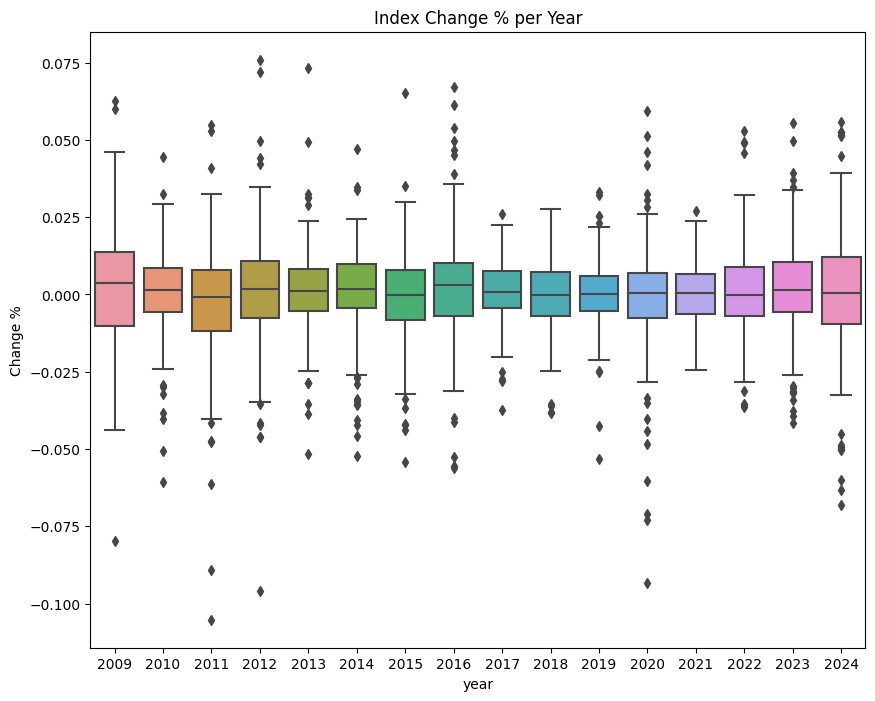

In [150]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='year', y='Change %')
ax.set_title('Index Change % per Year')
plt.show()

In [151]:
aug_df.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'quarter', 'year',
       'Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4',
       'Price_lag_5', 'Price_lag_6', 'Price_lag_7', 'Price_lag_8',
       'Price_lag_9', 'Price_lag_10', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3',
       'Open_lag_4', 'Open_lag_5', 'Open_lag_6', 'Open_lag_7', 'Open_lag_8',
       'Open_lag_9', 'Open_lag_10', 'High_lag_1', 'High_lag_2', 'High_lag_3',
       'High_lag_4', 'High_lag_5', 'High_lag_6', 'High_lag_7', 'High_lag_8',
       'High_lag_9', 'High_lag_10', 'Low_lag_1', 'Low_lag_2', 'Low_lag_3',
       'Low_lag_4', 'Low_lag_5', 'Low_lag_6', 'Low_lag_7', 'Low_lag_8',
       'Low_lag_9', 'Low_lag_10', 'Vol._lag_1', 'Vol._lag_2', 'Vol._lag_3',
       'Vol._lag_4', 'Vol._lag_5', 'Vol._lag_6', 'Vol._lag_7', 'Vol._lag_8',
       'Vol._lag_9', 'Vol._lag_10', 'Change %_lag_1', 'Change %_lag_2',
       'Change %_lag_3', 'Change %_lag_4', 'Change %_lag_5', 'Change %_lag_6',
       'Change %_lag_7', 

In [152]:
train = create_features(train,cols,lags)
test = create_features(test,cols,lags)

lag_features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
train_features = ['quarter', 'year']

for lf in lag_features:
    for lag in range(1,11):
        train_features.append(f'{lf}_lag_{lag}')

X_train = train[train_features]
Y_train = train['Price']

X_test = test[train_features]
Y_test = test['Price']

In [153]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=8000,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.001,
                       random_state=59)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=1000)

[0]	validation_0-rmse:11126.66053	validation_1-rmse:28058.76550
[1000]	validation_0-rmse:4135.59793	validation_1-rmse:11481.57918
[2000]	validation_0-rmse:1547.69571	validation_1-rmse:4897.89975
[3000]	validation_0-rmse:599.60377	validation_1-rmse:2470.57706
[4000]	validation_0-rmse:271.19144	validation_1-rmse:1698.61963
[5000]	validation_0-rmse:174.71119	validation_1-rmse:1490.75860
[6000]	validation_0-rmse:150.49236	validation_1-rmse:1403.00130
[7000]	validation_0-rmse:143.22342	validation_1-rmse:1352.05758
[7881]	validation_0-rmse:139.79631	validation_1-rmse:1333.14209


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=8000, n_jobs=None,
             num_parallel_tree=None, random_state=59, ...)

**The following graph shows the weight the model gave to each of the training features**

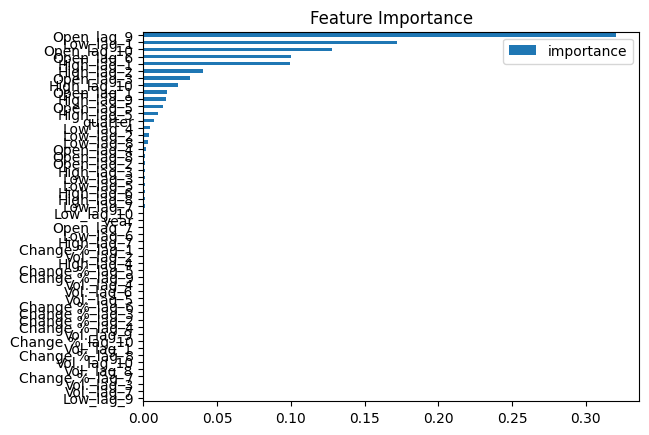

In [154]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

**The following graph shows our prediction on the test set vs the true values**

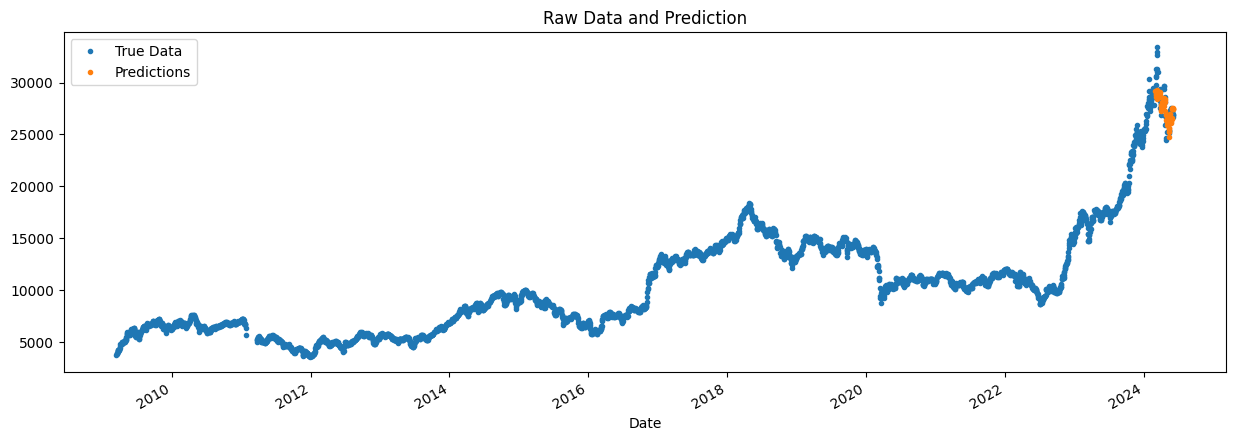

In [155]:
test['prediction'] = reg.predict(X_test)
aug_df = aug_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = aug_df[['Price']].plot(figsize=(15, 5), style='.')
aug_df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [156]:
test['prediction']

Date
2024-06-05    27520.316406
2024-06-04    27471.273438
2024-06-03    27453.937500
2024-06-02    27457.808594
2024-05-30    27470.152344
                  ...     
2024-03-07    28613.078125
2024-03-06    28846.835938
2024-03-05    29220.189453
2024-03-04    28825.078125
2024-03-03    29194.562500
Name: prediction, Length: 62, dtype: float32

In [157]:
Y_test

Date
2024-06-05    26634.30
2024-06-04    26973.00
2024-06-03    26834.47
2024-06-02    26869.85
2024-05-30    26922.76
                ...   
2024-03-07    31300.54
2024-03-06    29743.11
2024-03-05    30668.89
2024-03-04    30542.33
2024-03-03    29058.33
Name: Price, Length: 62, dtype: float64

In [159]:
rmse = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
avg_price = test['Price'].mean()

#Relative RMSE
rel_rmse = (rmse/avg_price) * 100
print(f"RMSE: {rmse}, True Average Price: {avg_price}")
print(f"Relative RMSE = {rel_rmse:.2f}%")

RMSE: 1333.0904887608415, True Average Price: 28013.045161290323
Relative RMSE = 4.76%
